<a href="https://colab.research.google.com/github/YB-nt/section_projects/blob/main/book_bata_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# install module

In [1]:
%%capture
import sys
import pandas as pd

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install tqdm

# pandas 출력할떄 생략 없애기
pd.set_option('display.max_seq_items', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#파일 불러오기

In [89]:

rating =pd.read_csv('/content/drive/MyDrive/bootcamp/Data set/도서데이터/BX-CSV-Dump/BX-Book-Ratings.csv' ,
                    delimiter=";",
                    header=0,
                    usecols =['User-ID','ISBN','Book-Rating'],
                    encoding= 'unicode_escape')

user_data=pd.read_csv('/content/drive/MyDrive/bootcamp/Data set/도서데이터/BX-CSV-Dump/BX-Users.csv' ,
                 delimiter=";",
                 header=0,
                 usecols=['User-ID','Location','Age'],
                 encoding= 'unicode_escape')

book_info = pd.read_csv('/content/drive/MyDrive/bootcamp/Data set/도서데이터/BX-CSV-Dump/BX-Books.csv' ,
                        delimiter=";",
                        header=0,
                        encoding= 'unicode_escape',
                        usecols=['ISBN', 'Book-Title','Book-Author','Year-Of-Publication','Publisher'])
                        # usecols=['ISBN', 'Book-Title','Book-Author','Year-Of-Publication','Publisher'])

rating.shape,user_data.shape,book_info.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((1149780, 3), (278858, 3), (271379, 5))

In [90]:
rating.rename(columns = {'Book-Rating' : 'Book_Rating',
                         'User-ID':'User_ID'},inplace = True)
user_data.rename(columns = {'User-ID':'User_ID',},inplace = True)

book_info.rename(columns = {'Book-Title' : 'Book_Title',
                            'Book-Author':'Book_Author',
                            'Year-Of-Publication':'Year_Of_Publication'},inplace = True)
rating.columns,user_data.columns,book_info.columns

(Index(['User_ID', 'ISBN', 'Book_Rating'], dtype='object'),
 Index(['User_ID', 'Location', 'Age'], dtype='object'),
 Index(['ISBN', 'Book_Title', 'Book_Author', 'Year_Of_Publication',
        'Publisher'],
       dtype='object'))

#EDA

## 데이터 살펴보기

In [9]:
rating.isna().sum()

User_ID        0
ISBN           0
Book_Rating    0
dtype: int64

In [10]:
user_data.isna().sum()

User_ID          0
Location         0
Age         110762
dtype: int64

In [11]:
book_info.isna().sum()

ISBN                   0
Book_Title             0
Book_Author            1
Year_Of_Publication    0
Publisher              2
dtype: int64

In [91]:
book_info=book_info.fillna('unknown')

In [92]:
book_info.shape,rating.shape,user_data.shape

((271379, 5), (1149780, 3), (278858, 3))

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(book_info, minimal=True).to_notebook_iframe()

In [ ]:
# book_info
# rating
# user_data

In [93]:
rating.sort_values(by='Book_Rating',ascending=False)

,User_ID,ISBN,Book_Rating
714920,173291,0590460609,10
439695,105221,0590353403,10
439659,105214,1573220221,10
113491,26421,1558743669,10
439664,105221,0064407667,10
...,...,...,...
484342,115120,0671026852,0
484343,115120,0671026860,0
484344,115120,0671027514,0
484345,115120,0671027522,0


In [43]:
from tqdm import tqdm
import numpy as np

## Book_info 이상치 해결

In [96]:
# book_info의 ISBN 수정 필요한 값들 ==> not_lenght10
strange_value_isbn =[]
for i in tqdm(book_info.ISBN):
    if(len(i)is not 10):
        strange_value_isbn.append(i)
strange_value_isbn

100%|██████████| 271379/271379 [00:00<00:00, 1902781.88it/s]


['0486404242\t', '3518365479<90', '3442248027  3', '0385722206  0']

In [97]:
# book_info의 author 확인 필요한 값들 ==> strange_value_author
strange_value_author =[]
author = list(book_info.Book_Author.unique())    
for i in author:
    for j in i:
        try:
            int(j)
            strange_value_author.append(i)
            break
        except:
            pass
# strange_value_author

In [98]:
strange_author_df = book_info[book_info.Book_Author.isin(strange_value_author)]
strange_value_author_temp =[]
for i in strange_author_df.Year_Of_Publication:
    try:
        int(i)
    except:
        strange_value_author_temp.append(i)

check_author_index = strange_author_df[strange_author_df.Year_Of_Publication.isin(strange_value_author_temp)].index
check_author_index

Int64Index([104317, 112280, 144056, 180187, 209550, 220744, 221691], dtype='int64')

In [99]:
# book_info의 year 수정 필요한 값들 ==> strange_value_year
strange_value_year=[]
for i in book_info.Year_Of_Publication.unique():
    temp = str(i)
    if(len(temp)!=4):
        strange_value_year.append(i)

chek_year = book_info[book_info.Year_Of_Publication.isin(strange_value_year)]
year_temp =[]

for i in tqdm(chek_year.Year_Of_Publication):
    temp =str(i)
    if(len(temp)<2):
        continue
    else:
        year_temp.append(i)

year_temp=list(year_temp)   


100%|██████████| 4641/4641 [00:00<00:00, 813548.08it/s]


위에서 이상한 값들은 raw전체적으로 확인이 필요하다.

In [100]:
#Year_Of_Publication
check_year_index=list(book_info[book_info.Year_Of_Publication.isin(year_temp)].index)
# ISBN
check_isbn_index = list(book_info[book_info.ISBN.isin(strange_value_isbn)].index)
# Book_Author
# check_author_index = list(book_info[book_info.Book_Author.isin(strange_value_author)].index)



Book_Author 의 값중에서는 완전히 필터링이 된것이 아니기 떄문에  한번더 체크를 해주어야된다.

In [101]:
import re
checking_url_check = book_info[book_info.Book_Author.isin(strange_value_author)]
p = r'http://'
# checking_date_temp #의 값을 확인해보니 값이 호출될떄 &amp 값이 들어간 경우 밀려있는 것을 알 수 있다.
# 이렇게 밀림 현상이 일어난 값들의 index값을 불러와준다.
check_author_index_r = list(checking_url_check[checking_url_check.Publisher.str.match(p)].index)
check_author_index_r


[112280, 209550, 220744, 221691]

이제 문제가 있을것으로 예상되는 값을 합쳐준다.

In [102]:
total_check_index = []
total_check_index.extend(check_year_index)
# total_check_index.extend(check_isbn_index)
# isbn의 값은 밀림 현상으로 일어난 문제가 아니다.
total_check_index.extend(check_author_index)
print('중복제거 이전 index length :',len(total_check_index))
total_check_index= list(set(total_check_index))
print('중복제거 이후 index length :',len(total_check_index))


need_eda_df = book_info[book_info.index.isin(total_check_index)]

중복제거 이전 index length : 30
중복제거 이후 index length : 23


In [103]:
# ISBN 문제 해결 
chg_isbn_temp =[]
# check_isbn_index = index
# strange_value_isbn = value
#보통 ISBN의 길이가 10개인것으로 추측되므로 10개 이후의 값을 지워준다.
for i in book_info.iloc[check_isbn_index].ISBN:
    chg_isbn_temp.append(i[:10])
# chg_isbn_temp
for count,value in enumerate(check_isbn_index):
    book_info.ISBN.iloc[value] = chg_isbn_temp[count]

for i in book_info.iloc[check_isbn_index].ISBN:
    if(len(i)!=10):
        print(False)

In [104]:
need_eda_df.head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
6450,0735201994,Peterman Rides Again: Adventures Continue with...,"the Catalog Business""",John Peterman,2000
43665,0330482750,"Three Novels: A Strange and Sublime Address""","""Afternoon Raag""","Freedom Song"";Amit Chaudhuri""",2001
51749,0413326608,"Upon my word!: More stories from My word!"" a p...","Tony Shryane""",Frank Muir,1974
92036,0440500702,Schrodinger's Cat Trilogy : The Universe Next ...,"""The Homing Pigeons""""",ROBERT A. WILSON,1988
104317,0373166982,"Please Say I Do"" (Three Weddings &amp","A Hurricane) (Harlequin American Romance, No ...",Karen T. Whittenburg,1997


In [105]:
book_info = book_info.drop(need_eda_df.index,axis=0)

## User_data 결측치 처리

In [106]:
user_data.sort_values(by='Age',ascending=False)

,User_ID,Location,Age
20856,20857,"stuttgart, baden-wuerttemberg, germany",244.0
8781,8782,"calgary, alberta, canada",239.0
58285,58286,"midvale, utah, usa",237.0
1578,1579,"akure, ondo/nigeria, nigeria",231.0
8457,8458,"milano, lombardia, italy",230.0
...,...,...,...
278849,278850,"sergnano, lombardia, italy",NaN
278853,278854,"portland, oregon, usa",NaN
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [107]:
user_data.dtypes

User_ID       int64
Location     object
Age         float64
dtype: object

In [108]:
user_data.loc[user_data.Age>90, 'Age'] = 90
user_data.loc[user_data.Age==0, 'Age'] = 1

In [109]:
user_data.Age.mean()

34.689950980392155

In [110]:
for count,value in tqdm(enumerate(user_data.Age)):
    if(np.isnan(value)):
        user_data.Age.iloc[count] = round(user_data.Age.mean(),0)
        
user_data

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
278858it [02:30, 1848.02it/s]


,User_ID,Location,Age
0,1,"nyc, new york, usa",35.0
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",35.0
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",35.0
...,...,...,...
278853,278854,"portland, oregon, usa",35.0
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",35.0
278856,278857,"knoxville, tennessee, usa",35.0


##Rating 이상치 해결

In [ ]:
# # rating의 ISBN 수정 필요한 값들 ==> not_lenght10
# rating_isbn =[]
# for i in tqdm(rating.ISBN):
#     if(len(i)is not 10):
#         rating_isbn.append(i)

# # for i in rating_isbn:
# #     if(len(i)>10):
# rating_isbn_temp=[]
# rating_isbn_index = rating[rating.ISBN.isin(rating_isbn)].index
# for i in tqdm(rating.iloc[rating_isbn_index].ISBN):
#     rating_isbn_temp.append(i[:10])

# for count,value in tqdm(enumerate(rating_isbn_index)):
#     rating.ISBN.iloc[value] = rating_isbn_temp[count]

# rating_drop_isbn=[]
# for i in tqdm(rating.iloc[rating_isbn_index].ISBN):
#     if(len(i)<10):
#         rating_drop_isbn.append(i)

In [148]:
rating = rating[rating.ISBN.isin(book_info.ISBN)]

In [149]:
rating.shape

(1031423, 3)

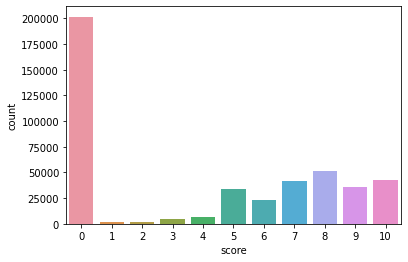

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

rating_score=[]
rating_isbn=[]
for i in range(0,11):
    rating_score.append(len(rating.groupby('Book_Rating').get_group(i).ISBN.unique()))
    rating_isbn.append(i)

rating_df = pd.DataFrame({"count":rating_score,"score":rating_isbn})
sns.barplot(x='score',y='count',data=rating_df);

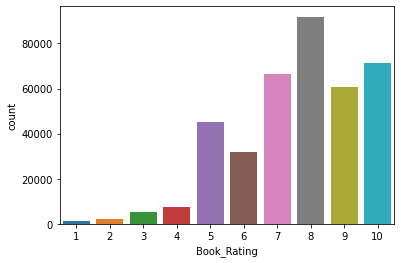

In [151]:
rating_score = rating[rating.Book_Rating != 0]
rating_bad_score = rating[rating.Book_Rating==0] #블랙컨슈머?
sns.countplot(x='Book_Rating',data=rating_score);

In [152]:
rating_score

,User_ID,ISBN,Book_Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9
...,...,...,...
1149771,276704,0743211383,7
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10


In [153]:
rating_bad_score

,User_ID,ISBN,Book_Rating
0,276725,034545104X,0
2,276727,0446520802,0
5,276733,2080674722,0
10,276746,0425115801,0
11,276746,0449006522,0
...,...,...,...
1149769,276704,059032120X,0
1149770,276704,0679752714,0
1149772,276704,080410526X,0
1149774,276704,0876044011,0


#Data Wrangling

In [162]:
total_rating= pd.DataFrame(rating_score.groupby(['ISBN']).Book_Rating.sum()) #book_rating 합친 값 
top10 = total_rating.sort_values(by='Book_Rating',ascending = False).head(10)
result_df=top10.merge(book_info,left_index= True,right_on='ISBN').rename(columns = {'Book_Rating' : 'Total_Rating'})

In [163]:
result_df

,Total_Rating,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


#모델링